# Generate HTML from Noise

In [5]:
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import time
import math
%matplotlib inline

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np
import pickle

In [ ]:
def time_since(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [6]:
data_path = "C:/Users/dhoomil.sheta/Downloads/Pix2Code Data/web/all_data"

epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100
# img_dims = 64
img_dims = 128

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

### Preprocess Data

In [ ]:
def transform(data, dims):
    data = mx.image.imresize(data, dims, dims)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

In [ ]:
img_list = []
for fname in os.listdir(data_path):
    if not fname.endswith('.png'):
        continue
    img = os.path.join(data_path, fname)
    img_arr = mx.image.imread(img)
    img_arr = transform(img_arr, img_dims)
    img_list.append(img_arr)

In [ ]:
train_iter = mx.image.ImageIter

### Load Data

In [ ]:
# with open("web_ui.pkl", "rb") as f:
#     img_list = pickle.load(f)

# print(f"Total {len(img_list)} HTML pages in dataset")
# print(f"Shape of data {img_list[0].shape}")

In [ ]:
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size, shuffle=True)
print(train_data.provide_data)

### Build the generator

In [ ]:
n_channels = 3
n_filters_g = 64
generator = nn.HybridSequential()
with generator.name_scope():
    # input is Z, going into a convolution
    generator.add(nn.Conv2DTranspose(n_filters_g * 8, 4, 1, 0, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 4 x 4
    generator.add(nn.Conv2DTranspose(n_filters_g * 4, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 8 x 8
    generator.add(nn.Conv2DTranspose(n_filters_g * 2, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 16 x 16
    generator.add(nn.Conv2DTranspose(n_filters_g, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 32 x 32
    generator.add(nn.Conv2DTranspose(n_channels, 4, 2, 1, use_bias=False))
    generator.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

### Build the discriminator

In [ ]:
n_filters_d = 64
discriminator = nn.HybridSequential()
with discriminator.name_scope():
    # input is (nc) x 64 x 64
    discriminator.add(nn.Conv2D(n_filters_d, 4, 2, 1, use_bias=False))
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 32 x 32
    discriminator.add(nn.Conv2D(n_filters_d * 2, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 16 x 16
    discriminator.add(nn.Conv2D(n_filters_d * 4, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 8 x 8
    discriminator.add(nn.Conv2D(n_filters_d * 8, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 4 x 4
    discriminator.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
# generator.initialize(mx.init.Normal(0.02), ctx=ctx)
# discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [ ]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()

metric = mx.metric.CustomMetric(facc)

In [ ]:
def train(epochs):
    print(f"Training for {epochs} epochs...")
    start = time.time()
    for epoch in range(epochs):
        train_data.reset()
        iteration = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            with autograd.record():
                # train with real image
                output = discriminator(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with autograd.record():
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

#             if iteration % 50 == 0:
#                 name, acc = metric.get()
                

        iteration = iteration + 1
        name, acc = metric.get()
        print(f'epoch {epoch}: iter {iteration} d_loss = {nd.mean(errD).asscalar()}, generator loss = {nd.mean(errG).asscalar()}, training acc = {acc}')
        print(f"Time: {time_since(start)}")
        metric.reset()
    print(f"Time: {time_since(start)}")

In [ ]:
train(20)

In [ ]:
generator.save_params(filename="dcgan_g_faces")
discriminator.save_params(filename="dcgan_d_faces")

In [ ]:
generator.load_params(filename="dcgan_g", ctx=ctx)
discriminator.load_params(filename="dcgan_d", ctx=ctx)

In [ ]:
plt.figure(figsize=(20,20))

def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [ ]:
def vis():
    plt.figure(figsize=(64,64))
    num_image = 12
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = generator(latent_z)
        plt.subplot(4, 3,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

In [ ]:
vis()

In [ ]:
train(20)

In [ ]:
ndf = 64
no_bias = True
fix_gamma = True
eps=1e-5 + 1e-12

In [ ]:
from PIL import Image

In [ ]:
img_names = filter(lambda x: 'png' in x, os.listdir(data_path))
img = Image.open(os.path.join(data_path, next(img_names)))

In [ ]:
img64 = img.resize([64, 64], Image.ANTIALIAS)
img128 = img.resize([128, 128], Image.ANTIALIAS)
img256 = img.resize([256, 256], Image.ANTIALIAS)

# New Section

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from data_utils import Dataset
from models import Generator, Discriminator

In [2]:
netG = Generator(name="dcgan_g_html")
netD = Discriminator(name="dcgan_d_html")

In [12]:
netG.load_params(ctx)
netD.load_params(ctx)

In [13]:
plt.figure(figsize=(128,128))

def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [14]:
def vis():
    plt.figure(figsize=(128,128))
    num_image = 6
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = netG(latent_z)
        plt.subplot(4, 3,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

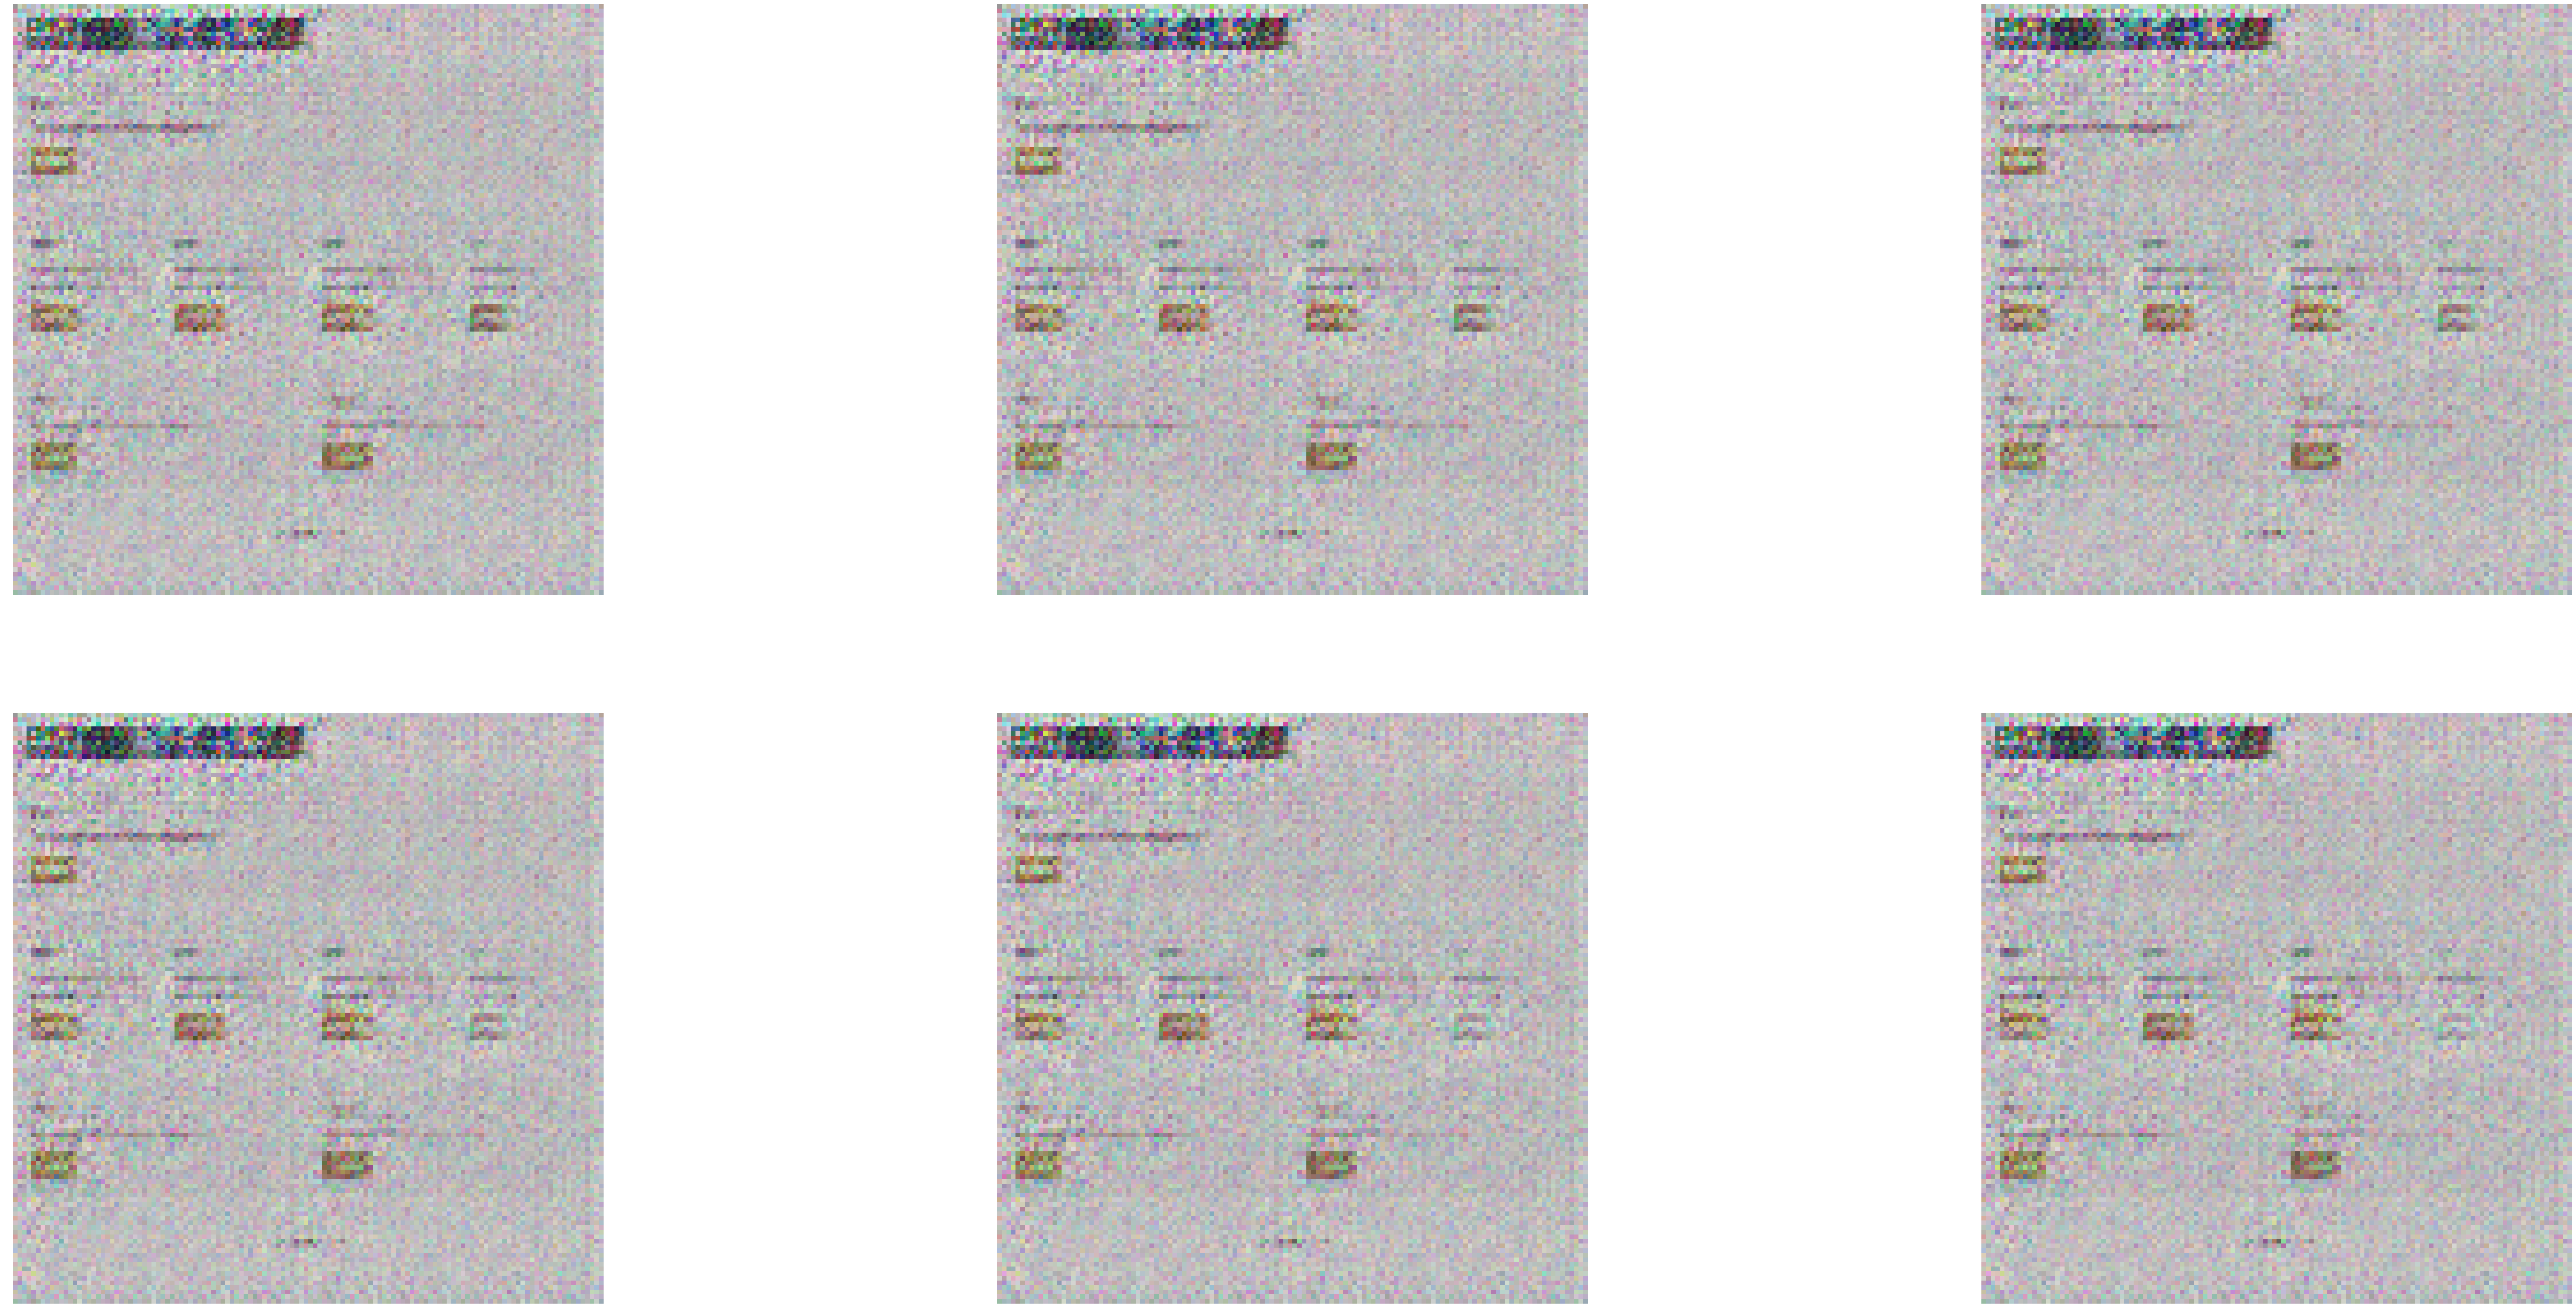

In [11]:
vis()